In [1]:
#обработка данных
import pandas as pd
import numpy as np
import missingno as msno

#визуализация
import matplotlib.pyplot as plt
import seaborn as sns

#модели машинного обучения
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#предпроцессоринг
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#метрики качества обучения
from sklearn.metrics import mean_squared_error as mse, r2_score

#отключение предупреждений Python
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('daily-website-visitors.csv')

In [3]:
data.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Row                2167 non-null   int64 
 1   Day                2167 non-null   object
 2   Day.Of.Week        2167 non-null   int64 
 3   Date               2167 non-null   object
 4   Page.Loads         2167 non-null   object
 5   Unique.Visits      2167 non-null   object
 6   First.Time.Visits  2167 non-null   object
 7   Returning.Visits   2167 non-null   object
dtypes: int64(2), object(6)
memory usage: 135.6+ KB


<AxesSubplot:>

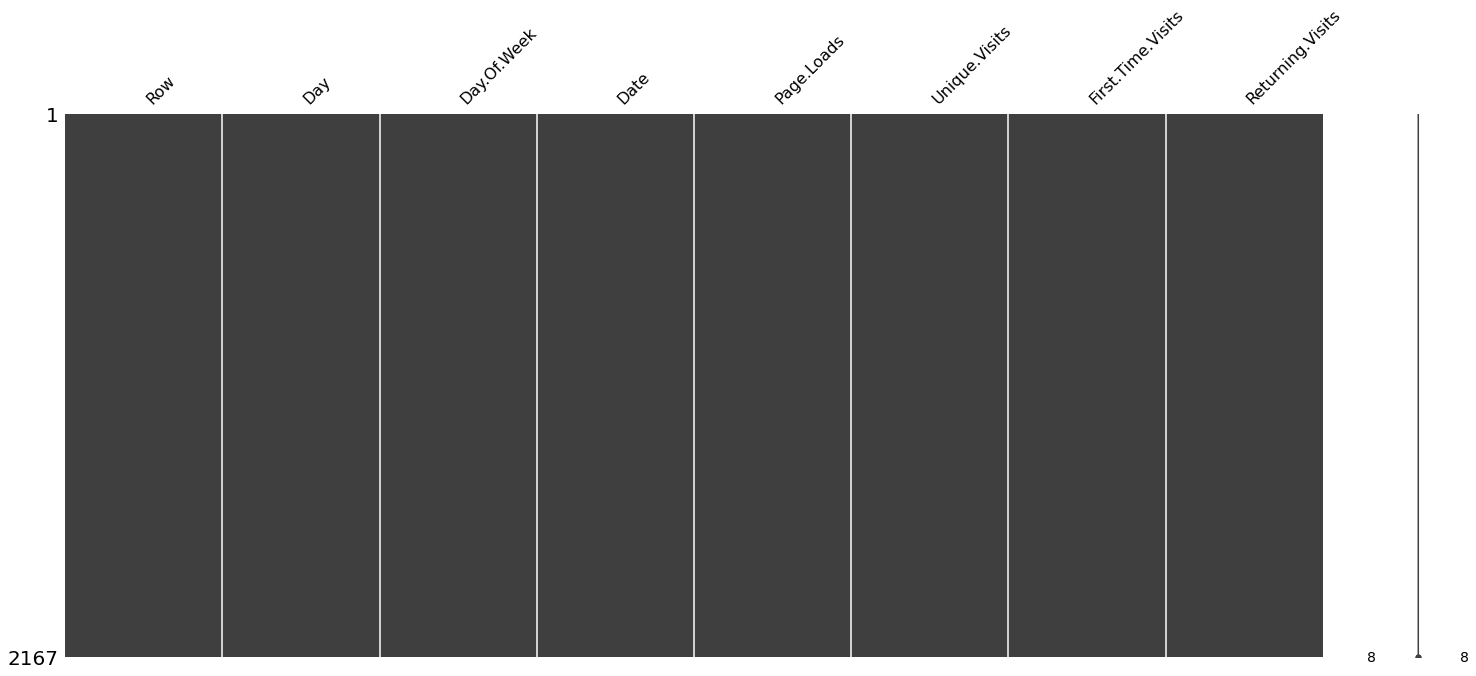

In [5]:
msno.matrix(data)

In [6]:
data.isna().sum()

Row                  0
Day                  0
Day.Of.Week          0
Date                 0
Page.Loads           0
Unique.Visits        0
First.Time.Visits    0
Returning.Visits     0
dtype: int64

<p>3 метрики для анализа посещаемости сайта: <br>
    DAU - дневная активность пользователей: количество страниц / количество уникальных пользователей за день <br>
    WAU - недельная активность пользователей: количество страниц / количество уникальных пользователей за неделю<br>
    MAU - месячная активность пользователей: количество страниц / количество уникальных пользователей за месяц <br><br>
    4 метрики для анализа заинтересованости посетителей:<br>
    SFW - Степень лояльности недельная = DAU / WAU * 100 <br>
    SFM - Степень лояльности месячная - DAU/MAU * 100 <br>
    ACU - Average Concurrent Use - среднее число посетителей за конкретный период <br>
</p>

In [7]:
data = data.replace(',', '', regex=True)\
    .rename(columns={'Page.Loads':'Loads', 'Unique.Visits':'UVisits', \
    'First.Time.Visits':'FTVisits', 'Returning.Visits':'RVisits'})

In [8]:
data = data.astype({'Date':np.datetime64, 'Loads':np.int32, 'UVisits':np.int32, 'FTVisits':np.int32, 'RVisits':np.int32})

In [9]:
data = data.drop(['Day', 'Row'], axis=1)

In [10]:
data['Day'] = data['Date'].dt.day
data['Week'] = data['Date'].dt.week
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

# Анализ посещаемости сайта 

In [11]:
#создадим 3 новые фичи - DAU, WAU и MAU
data['DAU'] = data['Loads'] / data['UVisits']

In [12]:
weekly_visits = data.groupby('Week')[['UVisits', 'Loads']].sum().reset_index()
weekly_visits['WAU'] = weekly_visits['Loads'] / weekly_visits['UVisits']
weekly_visits = weekly_visits.drop(['UVisits', 'Loads'], axis=1)

In [13]:
monthly_visits = data.groupby('Month')[['UVisits', 'Loads']].sum().reset_index()
monthly_visits['MAU'] = monthly_visits['Loads'] / monthly_visits['UVisits']
monthly_visits = monthly_visits.drop(['UVisits', 'Loads'], axis=1)

In [14]:
data = pd.merge(data, weekly_visits, on='Week')
data = pd.merge(data, monthly_visits, on='Month')

In [15]:
data = data.sort_values(by='Date')

In [16]:
#построим графики новых фичей и посмотрим, что они могут нам сказать

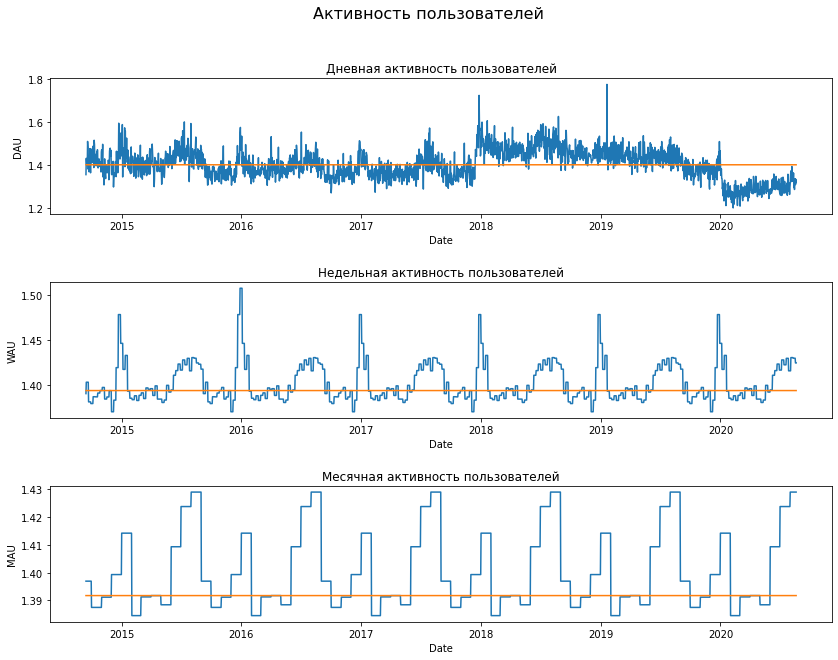

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('Активность пользователей', fontsize=16)
plt.subplots_adjust(hspace=0.5)


sns.lineplot(data=data, x='Date', y='DAU', ax=axs[0])
sns.lineplot(x=data['Date'], y=data['DAU'].median(), ax=axs[0])
axs[0].title.set_text('Дневная активность пользователей')

sns.lineplot(data=data, x='Date', y='WAU', ax=axs[1])
sns.lineplot(x=data['Date'], y=data['WAU'].median(), ax=axs[1])
axs[1].title.set_text('Недельная активность пользователей')

sns.lineplot(data=data, x='Date', y='MAU', ax=axs[2])
sns.lineplot(x=data['Date'], y=data['MAU'].median(), ax=axs[2])
axs[2].title.set_text('Месячная активность пользователей')

plt.show()

<hr>
<p style='font-size:20px; font-family: Roboto;'> С середины 2019 года мы видим тренд на снижение дневной активности пользователей. <b>COVID-19?</b> Остальные метрики показывают сезонную активность пользователей. </p>
<hr>

# Анализ заинтересованности

In [18]:
data['SFW'] = data['DAU']/ data['WAU'] * 100

In [19]:
data['SFM'] = data['DAU'] / data['MAU'] * 100

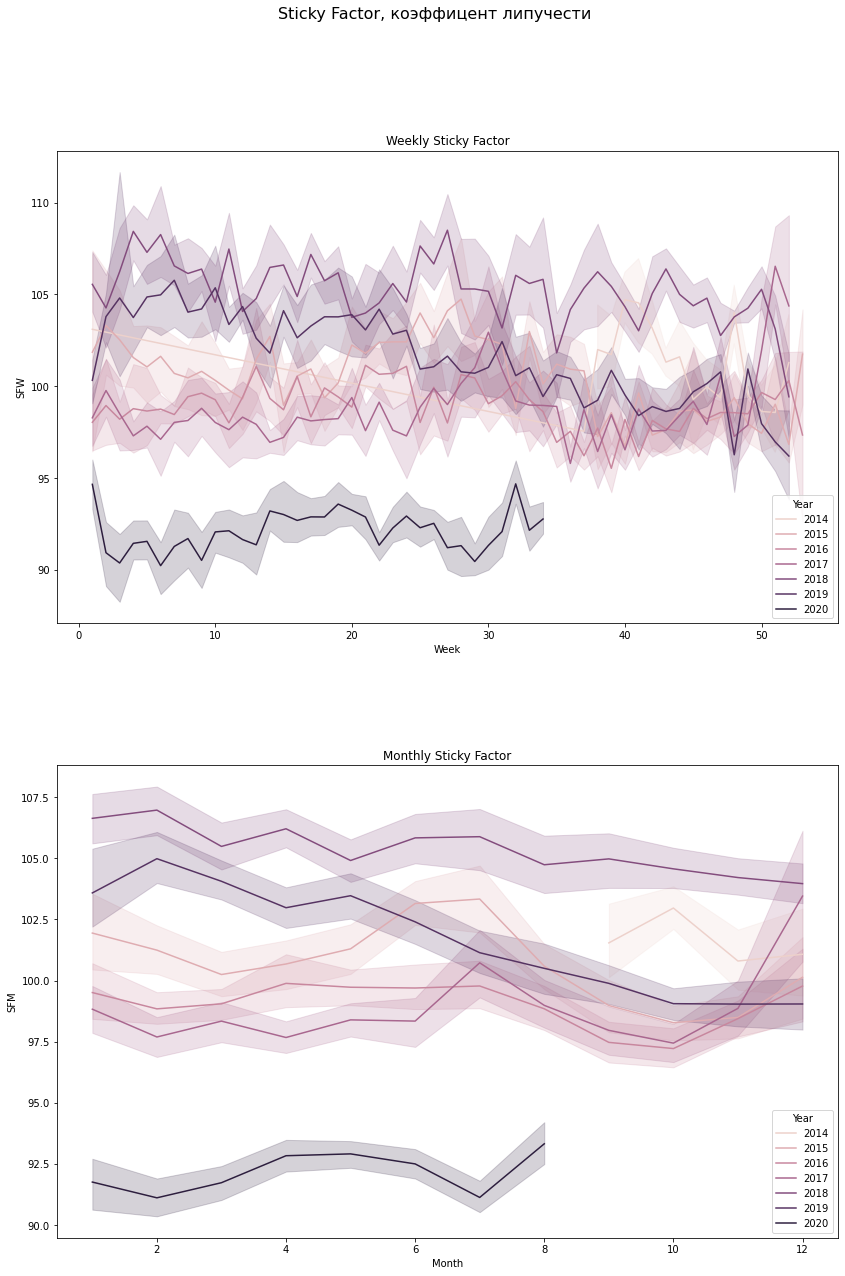

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(14, 20))
plt.subplots_adjust(hspace=0.3)
fig.suptitle('Sticky Factor, коэффицент липучести', fontsize=16)
sns.lineplot(data=data, x='Week', y='SFW', ax=axs[0], hue='Year')
axs[0].title.set_text('Weekly Sticky Factor')
sns.lineplot(data=data, x='Month', y='SFM', ax=axs[1], hue='Year')
axs[1].title.set_text('Monthly Sticky Factor')
plt.show()

<hr>
<p style='font-size:20px; font-family:Roboto;'>Достаточно высокий недельный и месячный Sticky Factor, что говорит о том, что пользователи не утрачивают интерес к сайту на протяжении года. Видно ежегодное повышение интереса в декабре. В 2020 году Sticky Factor упал до 92.5. <b>COVID-19?</b> </p>
<hr>

# Анализ средних

In [21]:
ACUW = data.groupby('Week')['UVisits', 'Loads'].mean().reset_index()
ACUW = ACUW.rename(columns={'UVisits':'ACUW'})
data = pd.merge(data, ACUW.drop('Loads', axis=1), on='Week')

In [22]:
ACUM = data.groupby('Month')['UVisits', 'Loads'].mean().reset_index()
ACUM = ACUM.rename(columns={'UVisits':'ACUM'})
data = pd.merge(data, ACUM.drop('Loads', axis=1), on='Month')

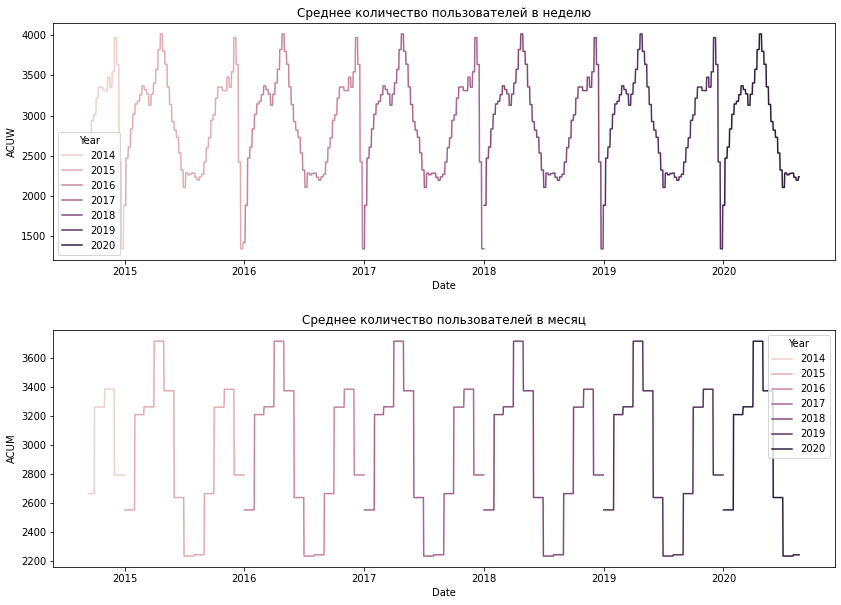

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(14, 10))
plt.subplots_adjust(hspace=0.3)
sns.lineplot(x=data['Date'], y=data['ACUW'], hue=data['Year'], ax=axs[0])
axs[0].title.set_text('Среднее количество пользователей в неделю')
sns.lineplot(x=data['Date'], y=data['ACUM'], hue=data['Year'], ax=axs[1])
axs[1].title.set_text('Среднее количество пользователей в месяц')
plt.show()

<hr>
<p style='font-size: 20px; font-family: Roboto;'>Если бы это был не синтетический набор данных, я бы предположил, что сайт никак не развивается - нету тренда на рост. Данные из года в год копируют друг друга почти на 100%</p>
<hr>

In [24]:
data

,Day.Of.Week,Date,Loads,UVisits,FTVisits,RVisits,Day,Week,Month,Year,DAU,WAU,MAU,SFW,SFM,ACUW,ACUM
0,1,2014-09-14,2146,1582,1430,152,14,37,9,2014,1.356511,1.390675,1.396922,97.543341,97.107093,2601.694444,2662.083832
1,2,2015-09-07,3330,2354,1963,391,7,37,9,2015,1.414613,1.390675,1.396922,101.721362,101.266428,2601.694444,2662.083832
2,3,2015-09-08,4734,3381,2833,548,8,37,9,2015,1.400177,1.390675,1.396922,100.683307,100.233016,2601.694444,2662.083832
3,4,2015-09-09,4801,3381,2845,536,9,37,9,2015,1.419994,1.390675,1.396922,102.108272,101.651608,2601.694444,2662.083832
4,5,2015-09-10,4399,3079,2575,504,10,37,9,2015,1.428711,1.390675,1.396922,102.735056,102.275589,2601.694444,2662.083832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162,4,2019-08-28,4627,3125,2623,502,28,35,8,2019,1.480640,1.423126,1.429030,104.041401,103.611549,2271.800000,2240.339080
2163,5,2019-08-29,4221,2982,2477,505,29,35,8,2019,1.415493,1.423126,1.429030,99.463658,99.052719,2271.800000,2240.339080
2164,6,2019-08-30,3025,2102,1727,375,30,35,8,2019,1.439106,1.423126,1.429030,101.122869,100.705075,2271.800000,2240.339080
2165,7,2019-08-31,1998,1386,1179,207,31,35,8,2019,1.441558,1.423126,1.429030,101.295224,100.876718,2271.800000,2240.339080


In [25]:
data[data.duplicated()]

,Day.Of.Week,Date,Loads,UVisits,FTVisits,RVisits,Day,Week,Month,Year,DAU,WAU,MAU,SFW,SFM,ACUW,ACUM


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167 entries, 0 to 2166
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day.Of.Week  2167 non-null   int64         
 1   Date         2167 non-null   datetime64[ns]
 2   Loads        2167 non-null   int32         
 3   UVisits      2167 non-null   int32         
 4   FTVisits     2167 non-null   int32         
 5   RVisits      2167 non-null   int32         
 6   Day          2167 non-null   int64         
 7   Week         2167 non-null   int64         
 8   Month        2167 non-null   int64         
 9   Year         2167 non-null   int64         
 10  DAU          2167 non-null   float64       
 11  WAU          2167 non-null   float64       
 12  MAU          2167 non-null   float64       
 13  SFW          2167 non-null   float64       
 14  SFM          2167 non-null   float64       
 15  ACUW         2167 non-null   float64       
 16  ACUM  

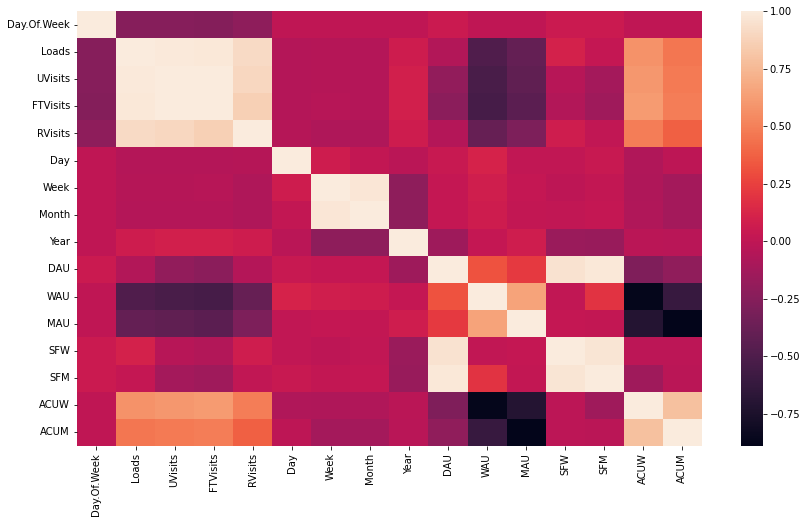

In [27]:
plt.figure(figsize=(14, 8))
sns.heatmap(data.corr())
plt.show()

In [28]:
data = data.drop('Date', axis=1)

In [29]:
data

,Day.Of.Week,Loads,UVisits,FTVisits,RVisits,Day,Week,Month,Year,DAU,WAU,MAU,SFW,SFM,ACUW,ACUM
0,1,2146,1582,1430,152,14,37,9,2014,1.356511,1.390675,1.396922,97.543341,97.107093,2601.694444,2662.083832
1,2,3330,2354,1963,391,7,37,9,2015,1.414613,1.390675,1.396922,101.721362,101.266428,2601.694444,2662.083832
2,3,4734,3381,2833,548,8,37,9,2015,1.400177,1.390675,1.396922,100.683307,100.233016,2601.694444,2662.083832
3,4,4801,3381,2845,536,9,37,9,2015,1.419994,1.390675,1.396922,102.108272,101.651608,2601.694444,2662.083832
4,5,4399,3079,2575,504,10,37,9,2015,1.428711,1.390675,1.396922,102.735056,102.275589,2601.694444,2662.083832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162,4,4627,3125,2623,502,28,35,8,2019,1.480640,1.423126,1.429030,104.041401,103.611549,2271.800000,2240.339080
2163,5,4221,2982,2477,505,29,35,8,2019,1.415493,1.423126,1.429030,99.463658,99.052719,2271.800000,2240.339080
2164,6,3025,2102,1727,375,30,35,8,2019,1.439106,1.423126,1.429030,101.122869,100.705075,2271.800000,2240.339080
2165,7,1998,1386,1179,207,31,35,8,2019,1.441558,1.423126,1.429030,101.295224,100.876718,2271.800000,2240.339080


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167 entries, 0 to 2166
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Day.Of.Week  2167 non-null   int64  
 1   Loads        2167 non-null   int32  
 2   UVisits      2167 non-null   int32  
 3   FTVisits     2167 non-null   int32  
 4   RVisits      2167 non-null   int32  
 5   Day          2167 non-null   int64  
 6   Week         2167 non-null   int64  
 7   Month        2167 non-null   int64  
 8   Year         2167 non-null   int64  
 9   DAU          2167 non-null   float64
 10  WAU          2167 non-null   float64
 11  MAU          2167 non-null   float64
 12  SFW          2167 non-null   float64
 13  SFM          2167 non-null   float64
 14  ACUW         2167 non-null   float64
 15  ACUM         2167 non-null   float64
dtypes: float64(7), int32(4), int64(5)
memory usage: 318.5 KB


In [31]:
target = data['UVisits']
data = data.drop('UVisits', axis=1)

In [38]:
x_train, x_val, y_train, y_val = train_test_split(data, target, random_state=12)

In [39]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1625, 15), (1625,), (542, 15), (542,))

In [40]:
#Linear regression

LRModel = LinearRegression().fit(x_train, y_train)

In [41]:
predict = LRModel.predict(x_val)
error = mse(y_val, predict)
error

7.346807971674997e-25

In [47]:
print(LRModel.predict[x_val.iloc[0:1, :]])

TypeError: 'method' object is not subscriptable

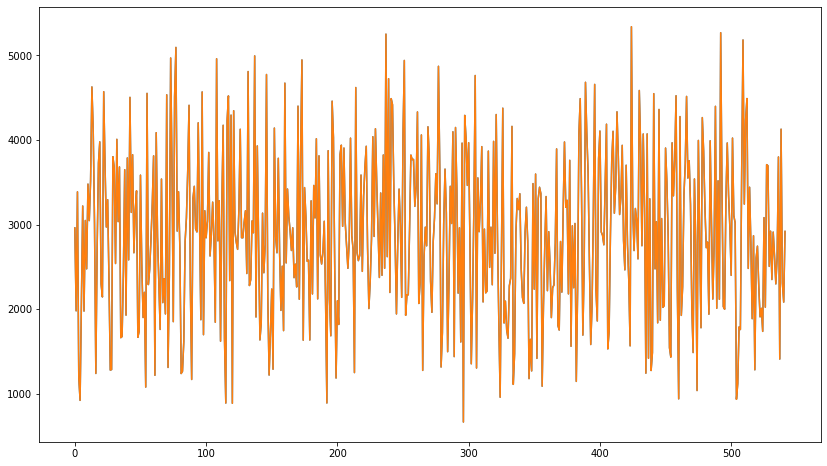

In [54]:
plt.figure(figsize=(14, 8))
plt.plot(range(len(y_val)), predict, range(len(y_val)), y_val)
plt.show()

In [55]:
R2error = r2_score(y_val, predict)

In [56]:
R2error

1.0

In [57]:
data

,Day.Of.Week,Loads,FTVisits,RVisits,Day,Week,Month,Year,DAU,WAU,MAU,SFW,SFM,ACUW,ACUM
0,1,2146,1430,152,14,37,9,2014,1.356511,1.390675,1.396922,97.543341,97.107093,2601.694444,2662.083832
1,2,3330,1963,391,7,37,9,2015,1.414613,1.390675,1.396922,101.721362,101.266428,2601.694444,2662.083832
2,3,4734,2833,548,8,37,9,2015,1.400177,1.390675,1.396922,100.683307,100.233016,2601.694444,2662.083832
3,4,4801,2845,536,9,37,9,2015,1.419994,1.390675,1.396922,102.108272,101.651608,2601.694444,2662.083832
4,5,4399,2575,504,10,37,9,2015,1.428711,1.390675,1.396922,102.735056,102.275589,2601.694444,2662.083832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162,4,4627,2623,502,28,35,8,2019,1.480640,1.423126,1.429030,104.041401,103.611549,2271.800000,2240.339080
2163,5,4221,2477,505,29,35,8,2019,1.415493,1.423126,1.429030,99.463658,99.052719,2271.800000,2240.339080
2164,6,3025,1727,375,30,35,8,2019,1.439106,1.423126,1.429030,101.122869,100.705075,2271.800000,2240.339080
2165,7,1998,1179,207,31,35,8,2019,1.441558,1.423126,1.429030,101.295224,100.876718,2271.800000,2240.339080
